# flux analysis
We will use a new variable to investigate jobs and nodes. This variable is 'flux' = (read_bytes +write_bytes)/CPU_time

We will use this as a performance measure. It is meant to represent throughput over time.

In [2]:
# import  epmt query
print('importing epmt_query')
import epmt_query as eq
# import matplot for better plotting functions
import sys
sys.path.insert(0,'/home/Avery.Kiihne/pip_experiment') #due to workspace funkyness with matplotlib
import matplotlib.pyplot as plt
import numpy as np
# import pandas. optional but helpful 'display.max_columns' arg shows all DataFrame columns when printing
print('importing pandas')
import pandas
pandas.set_option('display.max_columns', None)
#timing
import time


importing epmt_query
importing pandas


In [5]:
#get data
start = time.time()

jobs_all = eq.get_jobs(limit = 10000, before = -1, fmt = 'dict')

'''procs_all = eq.get_procs(jobs = jobs_all,
                       fmt='dict')
print(f'number of elements in jobs_all={len(procs_all)}')'''
print("time:",(time.time()-start)/60)

time: 1.5659338672955831


In [3]:
#pull data from jobs and store in dictionaries
#make list of unique nodes
node_list = [] 
for jobs_instance in range(len(jobs_all)):
    node_list.append(jobs_all[jobs_instance]['env_dict']['SLURM_NODELIST'])
node_list = sorted(set(node_list))
#make dictionary with each unique name as a key
CPU_runtime_dict = {}
wr_bytes_dict = {}
rd_bytes_dict = {}
flux_avg_dict = {}
#each tag group has its own key in variable dictonary
for dict_key in node_list:   
    CPU_runtime_dict[dict_key] = []
    wr_bytes_dict[dict_key] = []
    rd_bytes_dict[dict_key] = []
    flux_avg_dict[dict_key] = []
#now we can run through evry job and grab its specific stats to attach to its node
for jobs_instance in range(len(jobs_all)):   
    dict_key_instance = jobs_all[jobs_instance]['env_dict']['SLURM_NODELIST']
    if jobs_all[jobs_instance].get('read_bytes') is not None:
        if jobs_all[jobs_instance]['read_bytes'] + jobs_all[jobs_instance]['write_bytes'] > 0:   #if statements to adress problem cases
            CPU_runtime_dict[dict_key_instance].append(jobs_all[jobs_instance]['cpu_time'])
            wr_bytes_dict[dict_key_instance].append(jobs_all[jobs_instance]['write_bytes'])
            rd_bytes_dict[dict_key_instance].append(jobs_all[jobs_instance]['read_bytes'])
            flux_avg_dict[dict_key_instance].append((jobs_all[jobs_instance]['write_bytes']+jobs_all[jobs_instance]['read_bytes'])/jobs_all[jobs_instance]['cpu_time'])

In [4]:
#calculations portion
#we sepaflux nodes by type, as an nodes do different things than pp nodes
flux_avg = []
flux_avg_an = []
flux_avg_pp = []
flux_err_an = []
flux_err_pp = []
flux_error = []
pp_nodes = []
an_nodes = []
for node in node_list:
    if node.find('an') > -1:
        an_nodes.append(node)
    else:
        pp_nodes.append(node)
#average and error calculations for each node
for node_name in node_list:
    if node_name in pp_nodes:
        flux_avg_pp.append(sum(flux_avg_dict[node_name])/len(flux_avg_dict[node_name]))
        flux_err_pp.append(np.std(flux_avg_dict[node_name])/(len(flux_avg_dict[node_name]))**.5)
    else:
        flux_avg_an.append(sum(flux_avg_dict[node_name])/len(flux_avg_dict[node_name]))
        flux_err_an.append(np.std(flux_avg_dict[node_name])/(len(flux_avg_dict[node_name]))**.5)

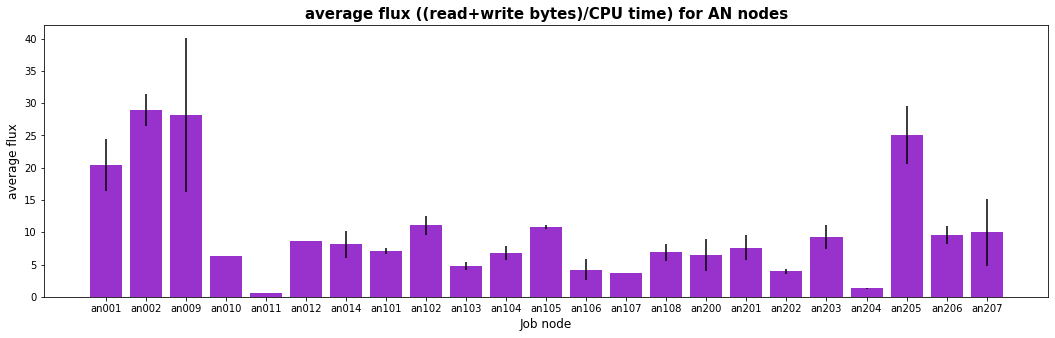

In [5]:
#Plot creation for rssmax of nodes
plt.style.use('default')
plt.figure(figsize = (18, 5))
plt.bar(an_nodes,flux_avg_an, yerr = flux_err_an, label = 'flux', color = 'darkorchid')
#bells n whistles
plt.title('average flux ((read+write bytes)/CPU time) for AN nodes', fontweight ='bold', fontsize = 15)
plt.ylabel('average flux', fontsize = 12)
plt.xlabel('Job node', fontsize = 12)
#plt.ylim(.9*min(rssmax_fin),1.1*max(rssmax_fin))
#plt.legend()
#cleanup
plt.tight_layout
plt.savefig('analysis_plots/general_plots/bar_flux_annodes.pdf', bbox_inches='tight', format = 'pdf')
plt.show()


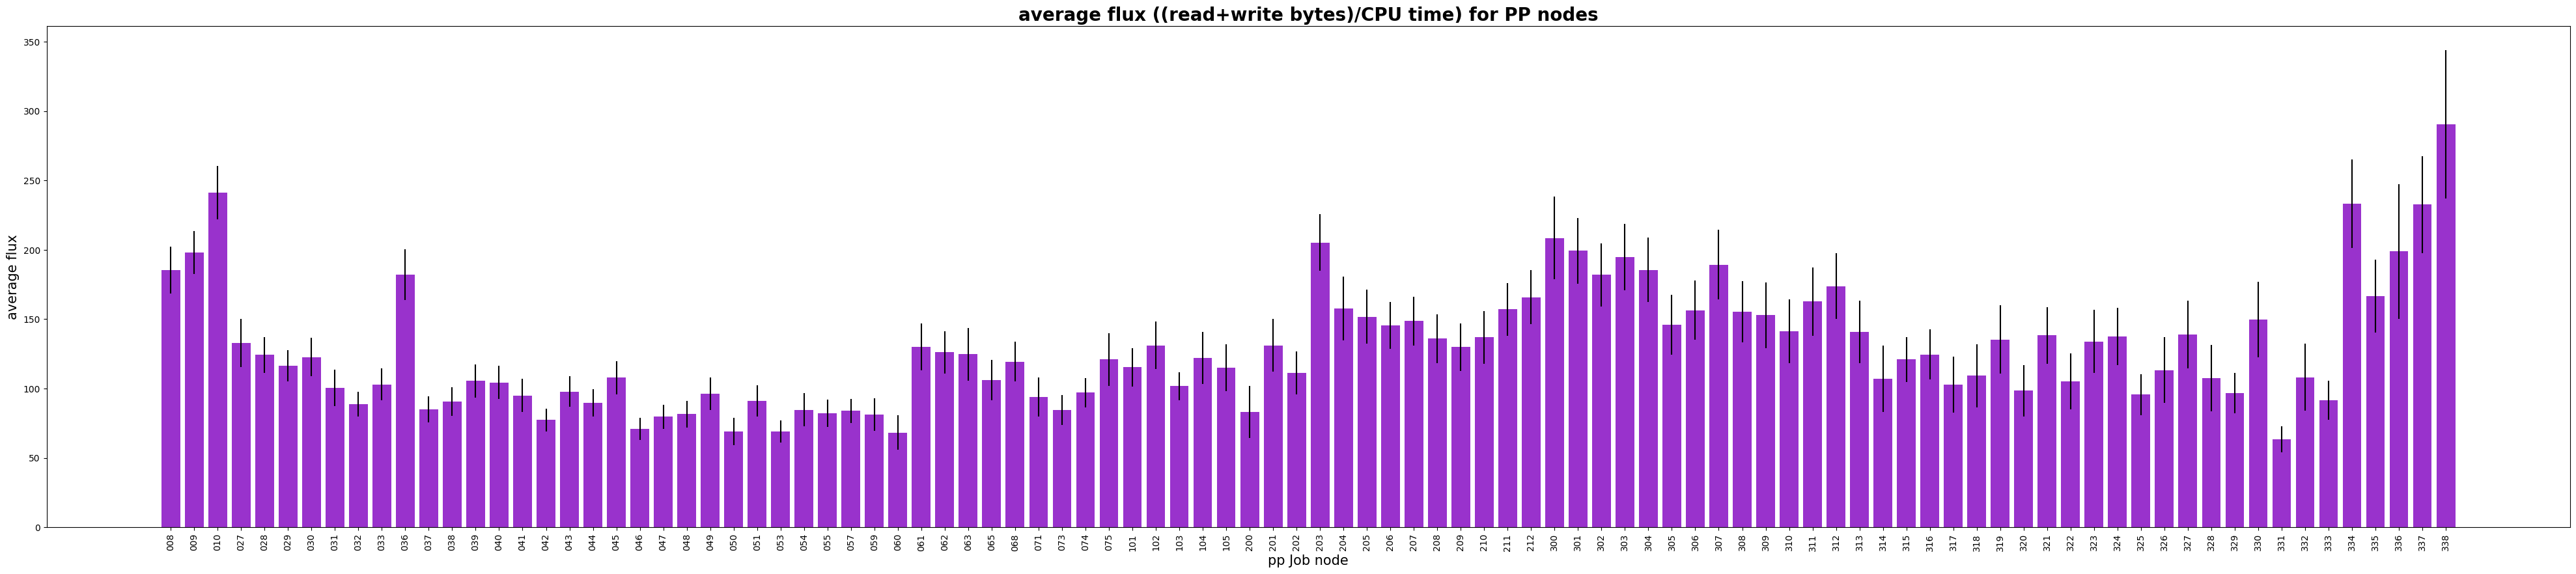

In [6]:
#Plot creation for rssmax of nodes
pp_nodes_short = []   #shorten node name by removing letters. this makes plot slighly cleaer
for aa in range(len(pp_nodes)):
    pp_nodes_short.append(pp_nodes[aa][2:5])
plt.style.use('default')
plt.figure(figsize = (50, 10))
plt.bar(pp_nodes_short,flux_avg_pp, yerr = flux_err_pp, label = 'flux', color = 'darkorchid')
#bells n whistles
plt.title('average flux ((read+write bytes)/CPU time) for PP nodes', fontweight ='bold', fontsize = 20)
plt.ylabel('average flux', fontsize = 15)
plt.xlabel('pp Job node', fontsize = 15)
plt.xticks( rotation=90)
#cleanup
plt.tight_layout
plt.savefig('analysis_plots/general_plots/bar_flux_ppnodes.pdf', bbox_inches='tight', format = 'pdf')
plt.show()

/home/fms/local/epmt/4.9.2-centos-7/epmt-install/epmt/epmt:8: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/fms/local/epmt/4.9.2-centos-7/epmt-install/epmt/epmt:8: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/fms/local/epmt/4.9.2-centos-7/epmt-install/epmt/epmt:8: UserWarning: FixedFormatter should only be used together with FixedLocator


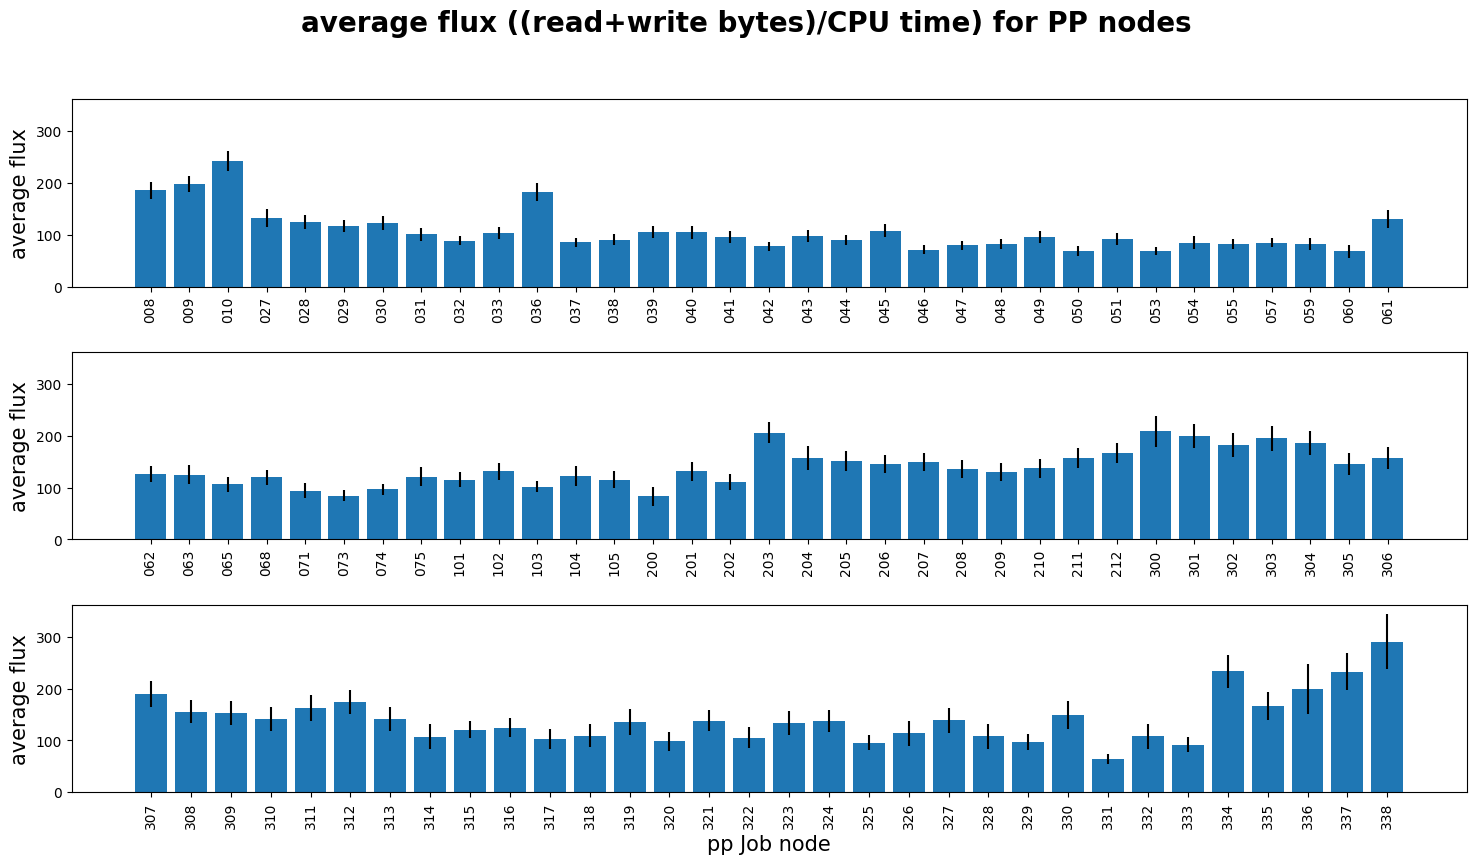

In [7]:
#make subplots breaking up long plot
plt.style.use('default')
fig, ax = plt.subplots(nrows=3,ncols=1,figsize=(18,9), sharex = 'none', sharey = 'all', gridspec_kw={'hspace': .35,'wspace':.05})
ax =ax.ravel()
plt.suptitle('average flux ((read+write bytes)/CPU time) for PP nodes', fontweight ='bold', fontsize = 20)
for aa in range(3):
    ax[aa].bar(pp_nodes_short[aa*33:(aa+1)*33],flux_avg_pp[aa*33:(aa+1)*33], yerr = flux_err_pp[aa*33:(aa+1)*33])
    ax[aa].set_xticklabels(pp_nodes_short[aa*33:(aa+1)*33], rotation=90)
    ax[aa].set_ylabel('average flux', fontsize = 15)

#bells n whistles
plt.xlabel('pp Job node', fontsize = 15)
plt.tight_layout
plt.savefig('analysis_plots/node_flux_subplot.pdf', format = 'pdf', bbox_inches='tight')
plt.show()

In [2]:
#massive loop to view multiple weeks back to back really easily
for aa in range(4):
    jobs_all = eq.get_jobs(limit = 25000, before = -(7+7*aa), after = -(14+7*aa), fmt = 'dict')
    
    #pull data from jobs and store in dictionaries
    #make list of unique nodes
    node_list = [] 
    for jobs_instance in range(len(jobs_all)):
        node_list.append(jobs_all[jobs_instance]['env_dict']['SLURM_NODELIST'])
    node_list = sorted(set(node_list))
    #make dictionary with each unique name as a key
    CPU_runtime_dict = {}
    wr_bytes_dict = {}
    rd_bytes_dict = {}
    flux_avg_dict = {}
    #each tag group has its own key in variable dictonary
    for dict_key in node_list:   
        CPU_runtime_dict[dict_key] = []
        wr_bytes_dict[dict_key] = []
        rd_bytes_dict[dict_key] = []
        flux_avg_dict[dict_key] = []
    #now we can run through evry job and grab its specific stats to attach to its node
    for jobs_instance in range(len(jobs_all)):   
        dict_key_instance = jobs_all[jobs_instance]['env_dict']['SLURM_NODELIST']
        if jobs_all[jobs_instance].get('read_bytes') is not None:
            if jobs_all[jobs_instance]['read_bytes'] + jobs_all[jobs_instance]['write_bytes'] > 0:   #if statements to adress problem cases
                CPU_runtime_dict[dict_key_instance].append(jobs_all[jobs_instance]['cpu_time'])
                wr_bytes_dict[dict_key_instance].append(jobs_all[jobs_instance]['write_bytes'])
                rd_bytes_dict[dict_key_instance].append(jobs_all[jobs_instance]['read_bytes'])
                flux_avg_dict[dict_key_instance].append((jobs_all[jobs_instance]['write_bytes']+jobs_all[jobs_instance]['read_bytes'])/jobs_all[jobs_instance]['cpu_time'])
    #calculations portion
    #we sepaflux nodes by type, as an nodes do different things than pp nodes
    flux_avg = []
    flux_avg_an = []
    flux_avg_pp = []
    flux_err_an = []
    flux_err_pp = []
    flux_error = []
    pp_nodes = []
    an_nodes = []
    for node in node_list:
        if node.find('an') > -1:
            an_nodes.append(node)
        else:
            pp_nodes.append(node)
    #average and error calculations for each node
    for node_name in node_list:
        if node_name in pp_nodes:
            flux_avg_pp.append(sum(flux_avg_dict[node_name])/len(flux_avg_dict[node_name]))
            flux_err_pp.append(np.std(flux_avg_dict[node_name])/(len(flux_avg_dict[node_name]))**.5)
        else:
            flux_avg_an.append(sum(flux_avg_dict[node_name])/len(flux_avg_dict[node_name]))
            flux_err_an.append(np.std(flux_avg_dict[node_name])/(len(flux_avg_dict[node_name]))**.5)
    #Plot creation for rssmax of nodes
    pp_nodes_short = []   #shorten node name by removing letters. this makes plot slighly cleaer
    for aa in range(len(pp_nodes)):
        pp_nodes_short.append(pp_nodes[aa][2:5])
    plt.style.use('default')
    plt.figure(figsize = (50, 10))
    plt.bar(pp_nodes_short,flux_avg_pp, yerr = flux_err_pp, label = 'flux', color = 'darkorchid')
    #bells n whistles
    plt.title('average flux ((read+write bytes)/CPU time) for PP nodes', fontweight ='bold', fontsize = 20)
    plt.ylabel('average flux', fontsize = 15)
    plt.xlabel('pp Job node', fontsize = 15)
    plt.xticks( rotation=90)
    #cleanup
    plt.tight_layout
    plt.savefig('analysis_plots/general_plots/bar_flux_ppnodes.pdf', bbox_inches='tight', format = 'pdf')
    plt.show()

IntegrityError: (raised as a result of Query-invoked autoflush; consider using a session.no_autoflush block if this flush is occurring prematurely)
(psycopg2.IntegrityError) duplicate key value violates unique constraint "host_job_associations_pkey"
DETAIL:  Key (jobid, hostname)=(36189316, pp075) already exists.

[SQL: INSERT INTO host_job_associations (jobid, hostname) VALUES (%(jobid)s, %(hostname)s)]
[parameters: {'jobid': '36189316', 'hostname': 'pp075'}]
(Background on this error at: http://sqlalche.me/e/gkpj)

In [4]:
len(jobs_all)

1000